In [67]:
import os
import cv2
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
DIR_TRAIN = "C:/Users/xuefeng/data/dogandcat/train/"
DIR_TEST = "C:/Users/xuefeng/data/dogandcat/test1/"
imgs = os.listdir(DIR_TRAIN) 
test_imgs = os.listdir(DIR_TEST)

In [28]:
def get_train_transform():
    return T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(15),
        T.RandomCrop(204),
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])
    
def get_val_transform():
    return T.Compose([
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])

In [88]:
class CatDogDataset(Dataset):
    
    def __init__(self, imgs, mode = "train", transforms = None):
        
        super().__init__()
        self.imgs = imgs
        self.mode = mode
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        image_name = self.imgs[idx]
        
        #Image.open is a lazy operation this function identifies the file, 
        #but the file remains open and the actual image data is not read from the file 
        #until you try to process the data.
        
        
        if self.mode == "train" or self.mode == "val":
            img = Image.open(DIR_TRAIN + image_name)
            img = img.resize((224, 224))
            ### Preparing class label
            label = 1 if image_name.split(".")[0] == "dog" else 0
            label = torch.tensor(label, dtype = torch.float32)

            ### Apply Transforms on image
            img = self.transforms(img)

            return img, label
        
        elif self.mode == "test":
            img = Image.open(DIR_TEST + image_name)
            img = img.resize((224, 224))
            ### Apply Transforms on image
            img = self.transforms(img)
            return img
            
        
    def __len__(self):
        return len(self.imgs)

In [89]:
train_imgs, val_imgs = train_test_split(imgs, test_size = 0.25)

In [90]:
train_dataset = CatDogDataset(train_imgs, mode = "train", transforms = get_train_transform())
val_dataset = CatDogDataset(val_imgs, mode = "val", transforms = get_val_transform())
test_dataset = CatDogDataset(test_imgs, mode = "test", transforms = get_val_transform())

train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 16,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    batch_size = 16,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 16,
    shuffle = True
)

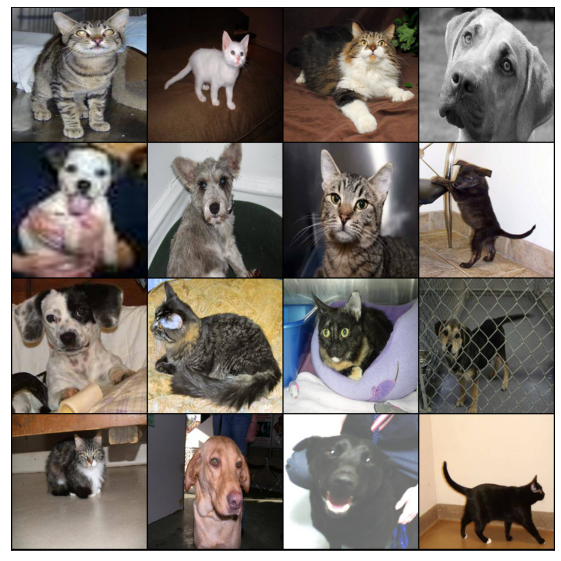

In [91]:
for images in test_data_loader:
    
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [50]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [51]:
device

device(type='cpu')

In [52]:
def accuracy(preds, trues):
    
    ### Converting preds to 0 or 1
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    
    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    
    ### Summing over all correct predictions
    acc = np.sum(acc) / len(preds)
    
    return (acc * 100)

In [53]:
def train_one_epoch(train_data_loader):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in train_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Reseting Gradients
        # optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
        optimizer.zero_grad()
        
        #Forward
        preds = model(images)
        
        #Calculating Loss# Loss Function: Binary cross entroy loss criterion = nn.BCELoss()
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
        #Backward
        _loss.backward()
        optimizer.step()
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time

In [54]:
def val_one_epoch(val_data_loader, best_val_acc):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in val_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    ###Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),"resnet50_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc

In [55]:
model = resnet50(pretrained = True)

# Modifying Head - classifier
# fc is fully connected layer. 
"""CNNs capture better representation of data and hence we don't need to do feature engineering. 
Classification: After feature extraction we need to classify the data into various classes, 
this can be done using a fully connected (FC) neural network"""
model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\xuefeng/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
24.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

57.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

93.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp

In [56]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function: Binary cross entroy loss
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 10

In [57]:
best_val_acc = 0
for epoch in range(epochs):
    
    ###Training
    loss, acc, _time = train_one_epoch(train_data_loader)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)
    
    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))


Training
Epoch 1
Loss : 0.1455
Acc : 94.1489
Time : 319.6372

Validating
Epoch 1
Loss : 0.0659
Acc : 97.6562
Time : 43.8157

Training
Epoch 2
Loss : 0.0379
Acc : 98.7878
Time : 321.8574

Validating
Epoch 2
Loss : 0.0521
Acc : 97.4609
Time : 41.3344

Training
Epoch 3
Loss : 0.0535
Acc : 98.3378
Time : 317.3445

Validating
Epoch 3
Loss : 0.1332
Acc : 95.5859
Time : 43.7646

Training
Epoch 4
Loss : 0.0341
Acc : 98.8697
Time : 319.0209

Validating
Epoch 4
Loss : 0.0513
Acc : 98.4375
Time : 41.7913

Training
Epoch 5
Loss : 0.0587
Acc : 98.2048
Time : 319.9946

Validating
Epoch 5
Loss : 0.0594
Acc : 97.8516
Time : 42.2252

Training
Epoch 6
Loss : 0.0288
Acc : 99.2021
Time : 322.2022

Validating
Epoch 6
Loss : 0.1264
Acc : 95.8203
Time : 44.1465

Training
Epoch 7
Loss : 0.0325
Acc : 98.9362
Time : 323.6322

Validating
Epoch 7
Loss : 0.0763
Acc : 97.2656
Time : 42.3104

Training
Epoch 8
Loss : 0.0186
Acc : 99.4681
Time : 319.9649

Validating
Epoch 8
Loss : 0.0624
Acc : 97.0703
Time : 44.4967


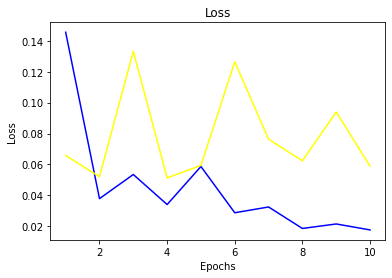

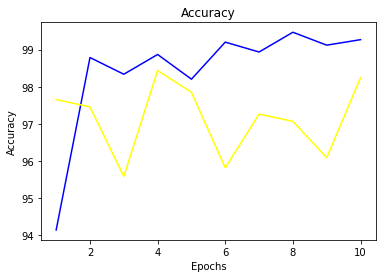

In [58]:
plt.title("Loss")
plt.plot(np.arange(1, 11, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, 11, 1), val_logs["loss"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, 11, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, 11, 1), val_logs["accuracy"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

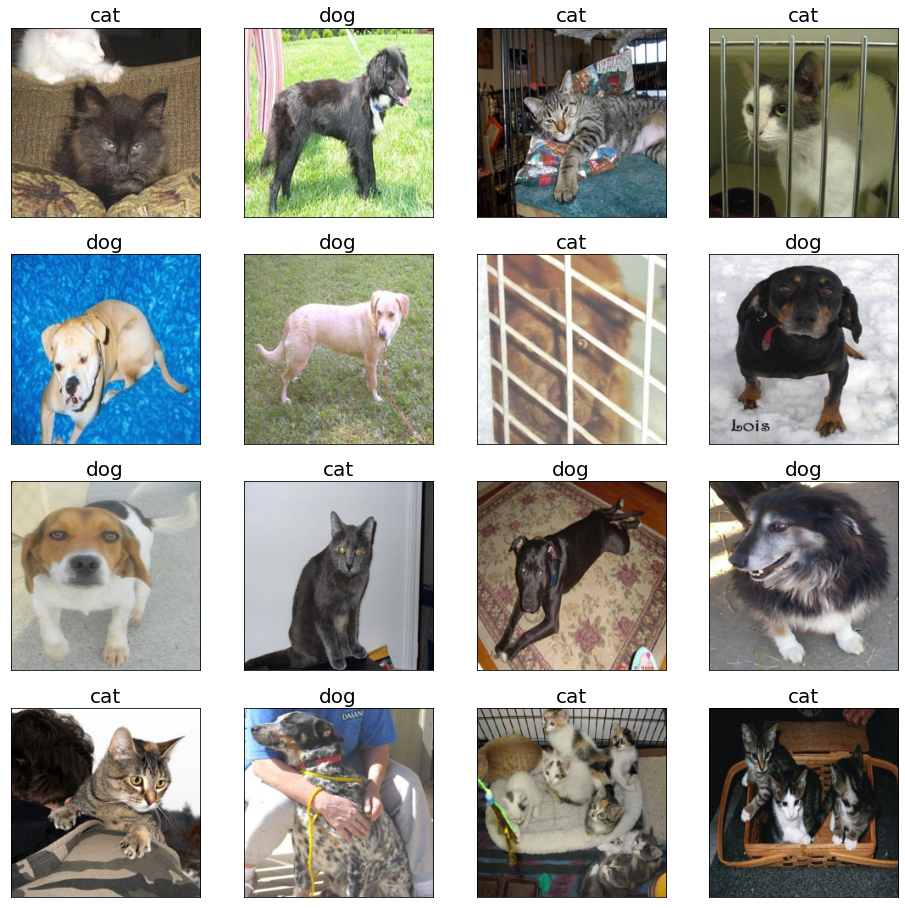

In [130]:
def recognize_catdog(net, test_iter, n=6):
    for images in test_iter:
        preds = model(images)
        preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
        break
        
    fig, _axs = plt.subplots(nrows=4, ncols=4, figsize = (16, 16))
    axs = _axs.flatten()
    
    for t, ax in enumerate(axs):
        ax.imshow(images[t].permute(1,2,0))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('dog' if preds[t] == 1 else "cat", fontsize = 20)

    return preds
    
test = recognize_catdog(model, test_data_loader, 64)
